In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable
# the train data points are spaced every 0.001 between 0 and 1 inclusive
train_x = Variable(torch.linspace(0, 1, 1001)).cuda()
# Use the sign function (-1 if value <0, 1 if value>0) to assign periodic labels to the data
train_y = Variable(torch.sign(torch.cos(train_x.data * (8 * math.pi)))).cuda()

In [3]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable
gpytorch.functions.use_toeplitz = False

In [4]:
# Create a model to classify, we use a GridInducingVariationalGP which exploits
# grid structure (the x data points are linspace)
# to get fast predictive distributions
class GPClassificationModel(gpytorch.models.GridInducingVariationalGP):
    def __init__(self):
        super(GPClassificationModel, self).__init__(grid_size=100, grid_bounds=[(0, 1)])
        # Near-zero constant mean
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        # RBF kernel as universal approximator
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        # Register RBF lengthscale as hyperparameter
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        # Calc predictive mean (zero)
        mean_x = self.mean_module(x)
        # Calc predictive covariance
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        # Make predictive distribution from predictive mean and covariance
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

# Initialize model
model = GPClassificationModel().cuda()
# Use Bernoulli Likelihood (warps via normal CDF to (0,1))
likelihood = BernoulliLikelihood().cuda()

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

def train():
    # Use adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    optimizer.n_iter = 0
    total_iter = 200
    for i in range(total_iter):
        # Zero gradients out for new iteration
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calculate loss
        loss = -model.marginal_log_likelihood(likelihood, output, train_y)
        # Calc gradients
        loss.backward()
        optimizer.n_iter += 1
        print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f' % (
            i + 1, total_iter, loss.data[0],
            model.covar_module.base_kernel_module.log_lengthscale.data.squeeze()[0],
        ))
        optimizer.step()
# Get time spent
%time train()

Iter 1/200 - Loss: 476.310   log_lengthscale: 0.000
Iter 2/200 - Loss: 393.227   log_lengthscale: -0.100
Iter 3/200 - Loss: 275.376   log_lengthscale: -0.181
Iter 4/200 - Loss: 236.201   log_lengthscale: -0.270
Iter 5/200 - Loss: 181.623   log_lengthscale: -0.353
Iter 6/200 - Loss: 161.046   log_lengthscale: -0.430
Iter 7/200 - Loss: 92.589   log_lengthscale: -0.500
Iter 8/200 - Loss: 49.672   log_lengthscale: -0.571
Iter 9/200 - Loss: 39.353   log_lengthscale: -0.639
Iter 10/200 - Loss: 23.415   log_lengthscale: -0.707
Iter 11/200 - Loss: 12.675   log_lengthscale: -0.767
Iter 12/200 - Loss: 7.710   log_lengthscale: -0.824
Iter 13/200 - Loss: 9.105   log_lengthscale: -0.882
Iter 14/200 - Loss: 9.167   log_lengthscale: -0.937
Iter 15/200 - Loss: 11.865   log_lengthscale: -0.994
Iter 16/200 - Loss: 10.952   log_lengthscale: -1.048
Iter 17/200 - Loss: 7.558   log_lengthscale: -1.104
Iter 18/200 - Loss: 7.142   log_lengthscale: -1.153
Iter 19/200 - Loss: 10.795   log_lengthscale: -1.200
It

Iter 162/200 - Loss: 0.592   log_lengthscale: -2.871
Iter 163/200 - Loss: 0.517   log_lengthscale: -2.873
Iter 164/200 - Loss: 0.498   log_lengthscale: -2.876
Iter 165/200 - Loss: 0.614   log_lengthscale: -2.878
Iter 166/200 - Loss: 0.609   log_lengthscale: -2.881
Iter 167/200 - Loss: 0.555   log_lengthscale: -2.883
Iter 168/200 - Loss: 0.561   log_lengthscale: -2.885
Iter 169/200 - Loss: 0.507   log_lengthscale: -2.887
Iter 170/200 - Loss: 0.504   log_lengthscale: -2.889
Iter 171/200 - Loss: 0.561   log_lengthscale: -2.890
Iter 172/200 - Loss: 0.560   log_lengthscale: -2.892
Iter 173/200 - Loss: 0.633   log_lengthscale: -2.893
Iter 174/200 - Loss: 0.567   log_lengthscale: -2.895
Iter 175/200 - Loss: 0.506   log_lengthscale: -2.896
Iter 176/200 - Loss: 0.490   log_lengthscale: -2.897
Iter 177/200 - Loss: 0.579   log_lengthscale: -2.898
Iter 178/200 - Loss: 0.693   log_lengthscale: -2.899
Iter 179/200 - Loss: 0.571   log_lengthscale: -2.900
Iter 180/200 - Loss: 0.727   log_lengthscale: 

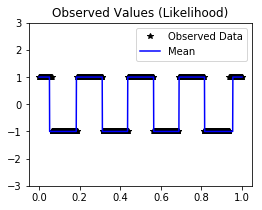

In [6]:
# Put mopdel and likelihood into eval mode
model.eval()
likelihood.eval()

# Initialize axes
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
# Test points are every 0.01 from 0 to 1 inclusive ## THIS IS SAME AS TRAINING 
test_x = Variable(torch.linspace(0, 1, 1001)).cuda()
# Make predictions from model output Gaussian warped through Bernoulli likelihood
predictions = likelihood(model(test_x))

# Define plotting function
def ax_plot(ax, rand_var, title):
    # Black stars for trainng data
    ax.plot(train_x.data.cpu().numpy(), train_y.data.cpu().numpy(), 'k*')
    # Based of prediction probability label -1 or 1
    pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1)
    # Plot test predictions as blue line
    ax.plot(test_x.data.cpu().numpy(), pred_labels.data.cpu().numpy(), 'b')
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

# Call plot
ax_plot(observed_ax, predictions, 'Observed Values (Likelihood)')